In [1]:
# Required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Load and fix sentiment labels
df = pd.read_csv("train_2K.csv")
df = df[['sentiment', 'reviewText']].dropna()
df['sentiment'] = df['sentiment'].replace({1: 0, 2: 1})  # 0 = negative, 1 = positive
df['reviewText'] = df['reviewText'].astype(str)


In [3]:
# 2. Clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['reviewText'] = df['reviewText'].apply(clean_text)



In [4]:
# 3. Tokenization
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['reviewText'])

sequences = tokenizer.texts_to_sequences(df['reviewText'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')



In [5]:
# 4. Train-test split
X = padded
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [7]:
# 5. Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



C:\Users\chien\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 6. Train with early stopping and learning rate reduction
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2)
]

history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_split=0.2, callbacks=callbacks)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.4917 - loss: 0.6941 - val_accuracy: 0.4563 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4786 - loss: 0.6939 - val_accuracy: 0.4563 - val_loss: 0.6950 - learning_rate: 0.0010
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4901 - loss: 0.6939 - val_accuracy: 0.4563 - val_loss: 0.6955 - learning_rate: 0.0010
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5184 - loss: 0.6926 - val_accuracy: 0.4563 - val_loss: 0.6957 - learning_rate: 1.0000e-04


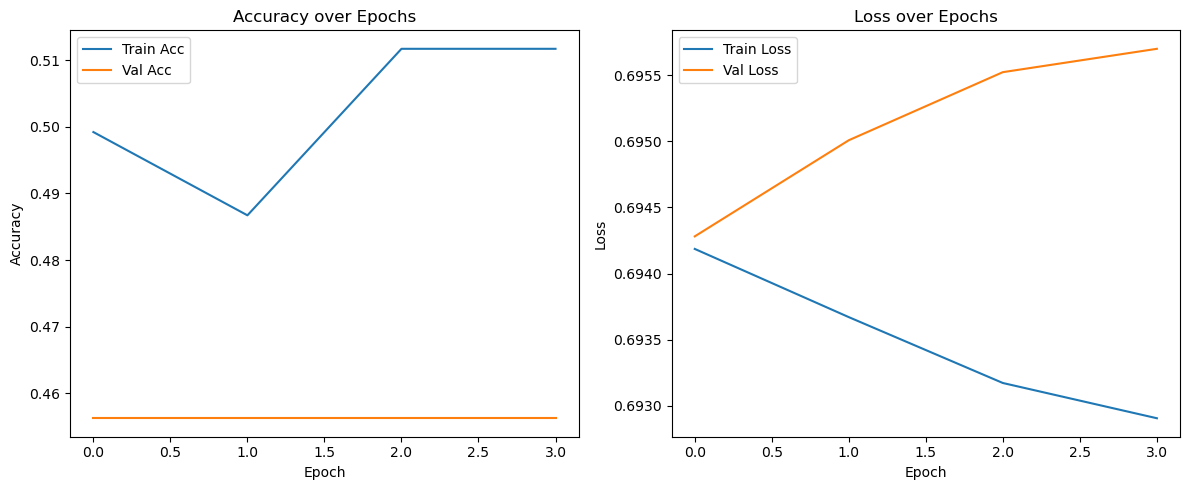

In [9]:
# 7. Visualize training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# 8. Evaluate on test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       199
           1       0.00      0.00      0.00       201

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



C:\Users\chien\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chien\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chien\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
# 9. Predict sentiment on new/unseen reviews

# Example: list of new reviews
new_reviews = [
    "This product is amazing and worked exactly as expected!",
    "Terrible quality. I want a refund.",
    "It's okay, not the best but not the worst either."
]

# Clean new reviews using the same cleaning function
new_reviews_cleaned = [clean_text(text) for text in new_reviews]

# Tokenize and pad
new_sequences = tokenizer.texts_to_sequences(new_reviews_cleaned)
new_padded = pad_sequences(new_sequences, maxlen=max_len, padding='post', truncating='post')

# Predict
predictions = model.predict(new_padded)
predicted_labels = (predictions > 0.5).astype("int32")

# Output predictions
for review, score, label in zip(new_reviews, predictions, predicted_labels):
    sentiment = "Positive" if label == 1 else "Negative"
    print(f"Review: \"{review}\"\n→ Predicted Sentiment: {sentiment} ({score[0]:.4f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Review: "This product is amazing and worked exactly as expected!"
→ Predicted Sentiment: Negative (0.4939)

Review: "Terrible quality. I want a refund."
→ Predicted Sentiment: Negative (0.4939)

Review: "It's okay, not the best but not the worst either."
→ Predicted Sentiment: Negative (0.4939)

